# Setup

## Installs

In [1]:
# Segmentation
# ! pip install --upgrade mxnet
# ! pip install torch==1.6.0+cpu torchvision==0.7.0+cpu -f https://download.pytorch.org/whl/torch_stable.html
# ! pip install --upgrade gluoncv

In [2]:
# Edge detection
# ! conda install scikit-image

In [3]:
# Depth estimation
# ! pip install -q transformers

## Imports

In [1]:
# Segmentation
import numpy as np

import mxnet as mx
from mxnet import image as mimage
from mxnet.gluon.data.vision import transforms

import gluoncv
from gluoncv.utils.viz import get_color_pallete
from gluoncv.data.transforms.presets.segmentation import test_transform

from matplotlib import pyplot as plt
import matplotlib.image as mpimg

import PIL.Image as pil

# using cpu
ctx = mx.cpu(0)

c:\Users\Kim\anaconda3\envs\pipeline1\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\Kim\anaconda3\envs\pipeline1\lib\site-packages\gluoncv\__init__.py:40: UserWarning: Both `mxnet==1.7.0` and `torch==1.6.0+cpu` are installed. You might encounter increased GPU memory footprint if both framework are used at the same time.
  warnings.warn(f'Both `mxnet=={mx.__version__}` and `torch=={torch.__version__}` are installed. '


In [2]:
# Edge detection
from skimage.feature import canny
from matplotlib import cm

In [3]:
# Depth estimation
from transformers import pipeline
import requests
import cv2

# Read and Transform File

In [4]:
filename = 'images/inputs/rooms/empty-room.png'

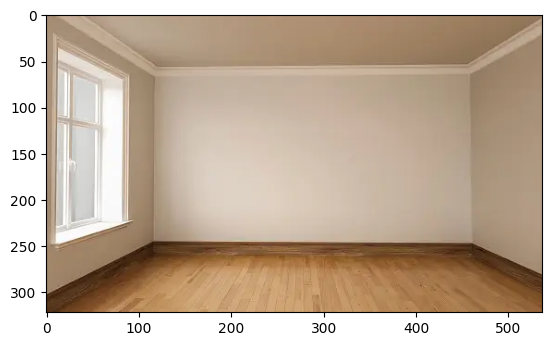

In [5]:
img = mimage.imread(filename)
plt.imshow(img.asnumpy())
plt.show()

In [6]:
img_t = test_transform(img, ctx)
img_t.shape

(1, 3, 322, 537)

# Semantic Segmentation

In [7]:
fcn_resnet50_ade = model = gluoncv.model_zoo.get_fcn_resnet50_ade(pretrained=True)
fcn_resnet101_ade = model = gluoncv.model_zoo.get_fcn_resnet101_ade(pretrained=True)

In [8]:
psp_resnet50_ade = model = gluoncv.model_zoo.get_psp_resnet50_ade(pretrained=True)
psp_resnet101_ade = model = gluoncv.model_zoo.get_psp_resnet101_ade(pretrained=True)

self.crop_size 480
self.crop_size 480
self.crop_size 480
self.crop_size 480


In [9]:
deeplab_resnet50_ade = model = gluoncv.model_zoo.get_deeplab_resnet50_ade(pretrained=True)
deeplab_resnet101_ade = model = gluoncv.model_zoo.get_deeplab_resnet101_ade(pretrained=True)

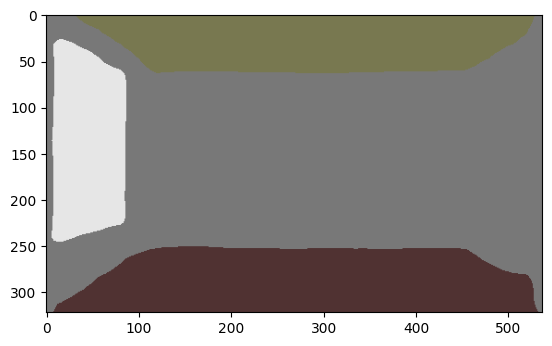

In [26]:
output = deeplab_resnet101_ade.predict(img_t)
predict = mx.nd.squeeze(mx.nd.argmax(output, 1)).asnumpy()

mask = get_color_pallete(predict, 'ade20k')
mask.save('images/outputs/segmentation-output.png')
plt.imshow(mask)

In [27]:
mmask = mpimg.imread('images/outputs/segmentation-output.png')
plt.imshow(mmask)
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'images/outputs/segmentation-output.png'

### Isolate walls

In [47]:
labs = []

for i in range(mmask.shape[0]):
    row = []
    for j in range(mmask.shape[1]):
        row.append(",".join(mmask[i, j].astype(str)))
    labs.append(row)

labs = np.array(labs)
labs.shape

(322, 537)

In [48]:
ind_0, ind_1 = np.where(labs != "0.47058824,0.47058824,0.47058824,1.0")
ind_2, ind_3 = np.where(labs == "0.47058824,0.47058824,0.47058824,1.0")

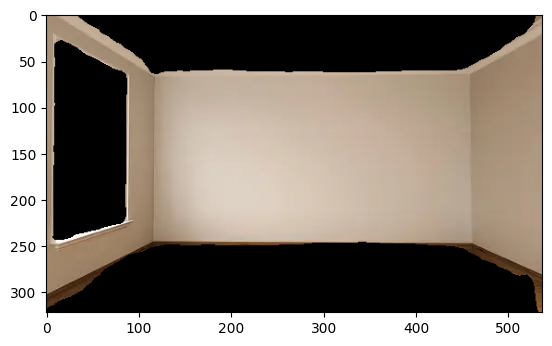

In [49]:
img2 = img.copy().asnumpy()
img2 = img2.astype(float)
img2[ind_0, ind_1] = np.array([0, 0, 0], dtype=float)
img2 = np.clip(img2, 0, 255)
segmented_img = pil.fromarray(img2.astype(np.uint8))
# img2 = img2.reshape((3, img2.shape[2], img2.shape[3]))
# img2 = img2.swapaxes(0, 1)
# img2 = img2.swapaxes(1, 2)
# print(img2.shape)

segmented_img.save('images/outputs/segmentation-walls-only.png')

plt.imshow(segmented_img)
plt.show()



# Depth Estimation

In [50]:
checkpoint = "vinvino02/glpn-nyu"
depth_estimator = pipeline("depth-estimation", model=checkpoint)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


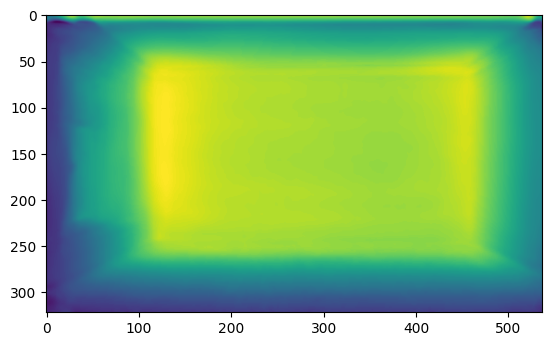

In [51]:
srcImage = pil.open(filename)
predictions = depth_estimator(srcImage)
depth_image = predictions["depth"]
# depth_image.save('images/outputs/depth-output.png')
plt.imsave('images/outputs/depth-output.png', depth_image)
plt.imshow(depth_image)
plt.show()

# Edge Detection

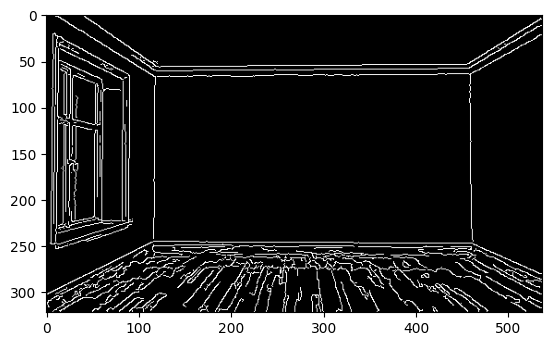

In [52]:
import cv2

# Read image
image = cv2.imread(filename)

# Convert image to grayscale
blur = cv2.blur(image, (3, 3))
gray = cv2.cvtColor(blur,cv2.COLOR_BGR2GRAY)
 
# Use canny edge detection
edges = cv2.Canny(gray,15,50,apertureSize=3)

edge_map = pil.fromarray(edges)
edge_map.save('images/outputs/edge-detection-output.png')

plt.imshow(edge_map, cmap=cm.gray)
plt.show()

# Finding corners

### Hough transform

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


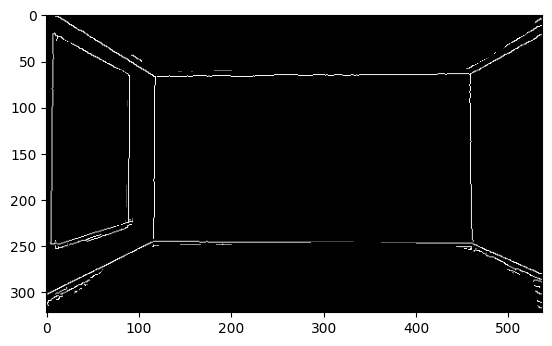

In [53]:
# Combine edge map and segmentation map
edge_map_array = np.asarray(edge_map.convert('RGB'))
segmented_edges = np.empty( (edge_map_array.shape[0], edge_map_array.shape[1], 3) )
segmented_edges[:] = np.nan
segmented_edges[ind_2, ind_3] = edge_map_array[ind_2, ind_3]
plt.imshow(segmented_edges)
segmented_edges = segmented_edges.astype(dtype=np.uint8)

segmented_edges = pil.fromarray(segmented_edges)
segmented_edges.save('images/outputs/segmented-edges.png')
# plt.imshow(edge_map)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


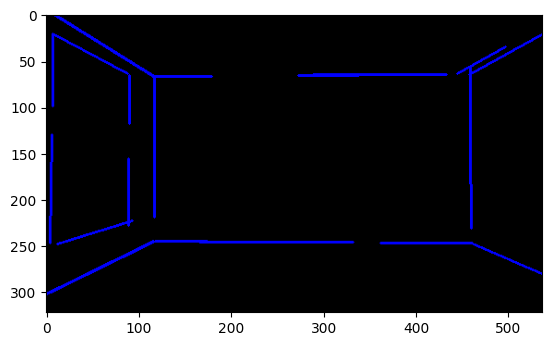

In [54]:
# Hough transform on segmented edges

# Read image
test = np.asarray(segmented_edges)
blank_image = np.empty( (test.shape[0], test.shape[1], 3) )
test = cv2.imread('images/outputs/segmented-edges.png')
test = cv2.cvtColor(test, cv2.COLOR_BGR2GRAY)

# Apply HoughLinesP method to 
# to directly obtain line end points
lines_list =[]
lines = cv2.HoughLinesP(
            test, # Input edge image
            1, # Distance resolution in pixels
            np.pi/180, # Angle resolution in radians
            threshold=50, # Min number of votes for valid line
            minLineLength=45, # Min allowed length of line
            maxLineGap=15 # Max allowed gap between line for joining them
            )
 
# Iterate over points
for points in lines:
      # Extracted points nested in the list
    x1,y1,x2,y2=points[0]
    # Draw the lines joing the points
    # On the original image
    cv2.line(blank_image,(x1,y1),(x2,y2),(0,0,255),2)
    # Maintain a simples lookup list for points
    lines_list.append([(x1,y1),(x2,y2)])
     
# Save the result image
cv2.imwrite('images/outputs/hough-output.png',blank_image)
plt.imshow(blank_image)

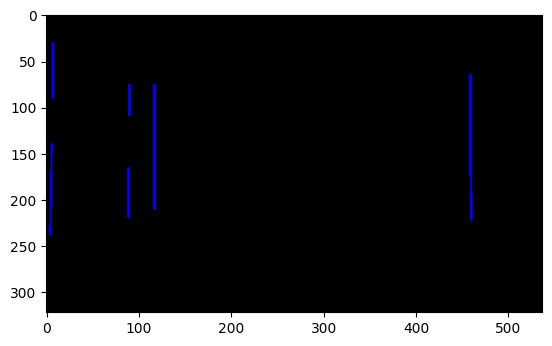

In [55]:
# https://www.youtube.com/watch?v=veoz_46gOkc
hough_img = cv2.imread('images/outputs/hough-output.png')
kernel = np.ones((20,1), np.uint8)
vertical_lines = cv2.erode(hough_img, kernel, iterations=1)
cv2.imwrite('images/outputs/hough_corners.png',vertical_lines)

plt.imshow(vertical_lines)
plt.show()

In [56]:
hough_corners = []

# corners = mpimg.imread('images/outputs/corners.png')
corners = plt.imread('images/outputs/hough_corners.png')[:, :, :3] * 255

colours = []

for i in range(corners.shape[0]):
    row = []
    for j in range(corners.shape[1]):
        row.append(",".join(corners[i, j].astype(str)))
    colours.append(row)

colours = np.array(colours)

# Find indices where there is red
ind_x, hough_corners = np.where(colours == "255.0,0.0,0.0")
# Round numbers to nearest 10 and then take only unique ones
# hough_corners = np.round(hough_corners, -1)
# hough_corners = np.unique(hough_corners)

print(hough_corners)

[7 6 7 ... 4 5 4]


### Depth change to find corners

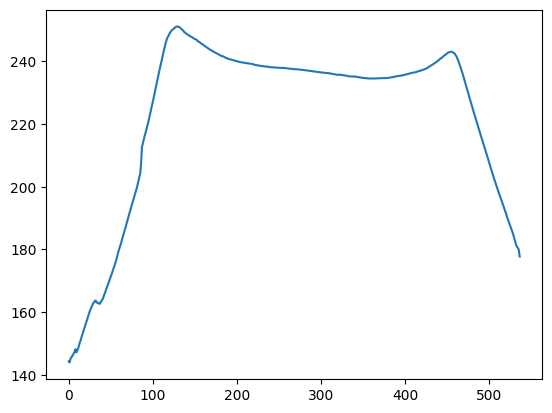

In [57]:
# # Find the mean depth for each column (1px wide) in the wall depth map and plot

test_depth = np.array(depth_image).copy().astype(float)
test_depth[ind_0, ind_1] = np.nan

y = np.nanmean(test_depth, axis=0)

plt.plot(y)

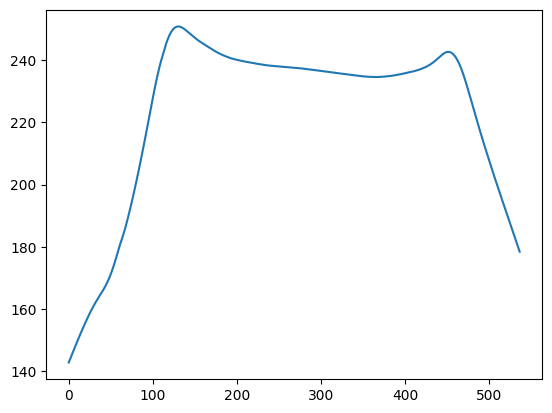

In [58]:
# Smooth using savgol filter
from scipy.signal import savgol_filter

y = savgol_filter(y, 51, 3) # window size 51, polynomial order 3
plt.plot(y)


#### Savitzky-Golay filter

c:\Users\Kim\anaconda3\envs\pipeline1\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


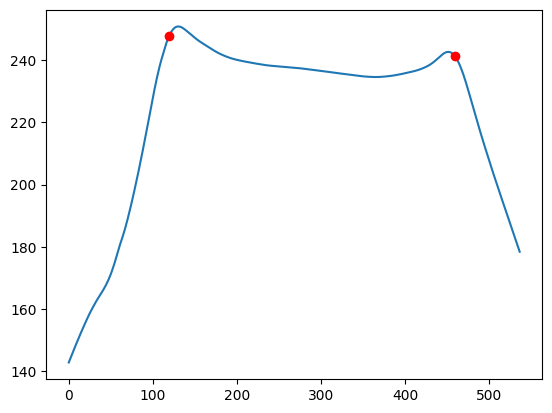

In [59]:
# https://stackoverflow.com/questions/47519626/using-numpy-scipy-to-identify-slope-changes-in-digital-signals

from matplotlib import gridspec
from scipy.signal import savgol_filter

# savgol_corners = depth_estimation.savgol_corners(mean_depth)
gs = gridspec.GridSpec(5, 1)
window = 55
der2 = savgol_filter(y, window_length=window, polyorder=2, deriv=2)
max_der2 = np.nanmax(np.abs(der2))
large = np.where(np.abs(der2) > max_der2/2)[0]
gaps = np.diff(large) > window
begins = np.insert(large[1:][gaps], 0, large[0])
ends = np.append(large[:-1][gaps], large[-1])
changes = ((begins+ends)/2).astype(np.int)
plt.plot(y)
plt.plot(changes, y[changes], 'ro')
plt.show()

savgol_corners = changes


#### Harris corner detection

[143, 144, 144, 145, 146, 146, 147, 148, 148, 149, 150, 150, 151, 151, 152, 153, 153, 154, 155, 155, 156, 156, 157, 158, 158, 159, 159, 160, 160, 161, 161, 162, 162, 163, 163, 164, 164, 164, 165, 165, 166, 166, 167, 167, 168, 168, 169, 169, 170, 171, 171, 172, 173, 174, 174, 175, 176, 177, 178, 179, 180, 181, 182, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 195, 196, 197, 198, 199, 201, 202, 203, 204, 206, 207, 208, 210, 211, 212, 214, 215, 217, 218, 219, 221, 222, 224, 225, 227, 228, 229, 231, 232, 233, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 245, 246, 247, 248, 248, 249, 249, 250, 250, 250, 250, 251, 251, 251, 251, 251, 251, 251, 251, 250, 250, 250, 250, 250, 249, 249, 249, 249, 249, 248, 248, 248, 248, 247, 247, 247, 247, 246, 246, 246, 246, 246, 246, 245, 245, 245, 245, 245, 245, 244, 244, 244, 244, 244, 243, 243, 243, 243, 243, 243, 243, 242, 242, 242, 242, 242, 242, 242, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 240, 240, 240, 240, 240, 240,

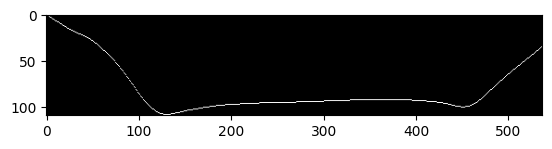

In [60]:
y_round = np.round(y.copy(), 0).astype(int)
print(list(y_round))
y_round = y_round - np.nanmin(y)
# y_round = np.round(y_round.copy(), 0)
y_round = np.where(y_round < 0, 0, y_round)
y_round = np.round(y_round, 0).astype(int)
print(list(y_round))
x = range(len(y_round))
matrix = np.zeros((np.amax(y_round)+1, len(x), 3))

for i in x:
    matrix[y_round[i], i] = [255, 255, 255]

matrix = matrix.astype(np.uint8)

matrix = pil.fromarray(matrix)
matrix.save("images/outputs/matrix-test.png")
plt.imshow(matrix)

In [61]:
print(y_round)

[  0   1   1   2   3   3   4   5   5   6   7   7   8   8   9  10  10  11
  12  12  13  13  14  15  15  16  16  17  17  18  18  19  19  20  20  21
  21  21  22  22  23  23  24  24  25  25  26  26  27  28  28  29  30  31
  31  32  33  34  35  36  37  38  39  39  40  41  42  43  44  45  46  47
  48  49  50  52  53  54  55  56  58  59  60  61  63  64  65  67  68  69
  71  72  74  75  76  78  79  81  82  84  85  86  88  89  90  92  93  94
  95  96  97  98  99 100 101 102 102 103 104 105 105 106 106 107 107 107
 107 108 108 108 108 108 108 108 108 107 107 107 107 107 106 106 106 106
 106 105 105 105 105 104 104 104 104 103 103 103 103 103 103 102 102 102
 102 102 102 101 101 101 101 101 100 100 100 100 100 100 100  99  99  99
  99  99  99  99  98  98  98  98  98  98  98  98  98  98  97  97  97  97
  97  97  97  97  97  97  97  97  97  97  97  97  96  96  96  96  96  96
  96  96  96  96  96  96  96  96  96  96  96  96  96  96  96  95  95  95
  95  95  95  95  95  95  95  95  95  95  95  95  9

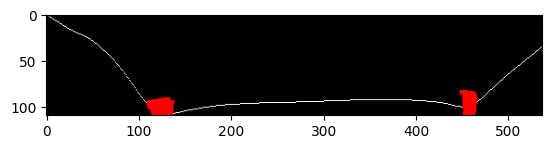

In [62]:
# Use cv2 method to detect 'corners'

image = cv2.imread('images/outputs/matrix-test.png')
operatedImage = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) 
  
# modify the data type 
# setting to 32-bit floating point 
operatedImage = np.float32(operatedImage) 
  
# apply the cv2.cornerHarris method 
# to detect the corners with appropriate 
# values as input parameters 
# dest = cv2.cornerHarris(operatedImage, 50, 29, 0.24)
dest = cv2.cornerHarris(operatedImage, 30, 5, 0.07)
  
# Results are marked through the dilated corners 
dest = cv2.dilate(dest, None) 
  
# Reverting back to the original image, 
# with optimal threshold value 
image[dest > 0.01 * dest.max()]=[255, 0, 0]

image = pil.fromarray(image.astype(np.uint8))
image.save("images/outputs/corners.png")
plt.imshow(image)

In [63]:
harris_corners = []

# corners = mpimg.imread('images/outputs/corners.png')
corners = plt.imread('images/outputs/corners.png')[:, :, :3] * 255

colours = []

for i in range(corners.shape[0]):
    row = []
    for j in range(corners.shape[1]):
        row.append(",".join(corners[i, j].astype(str)))
    colours.append(row)

colours = np.array(colours)

# Find indices where there is red
ind_x, harris_corners = np.where(colours == "255.0,0.0,0.0")
# # Round numbers to nearest 10 and then take only unique ones
# harris_corners = np.round(harris_corners, -1)
# harris_corners = np.unique(harris_corners)

# print(harris_corners)

### Combing corner detection methods

In [64]:
print(savgol_corners)
print(hough_corners)
print(harris_corners)

[119 459]
[7 6 7 ... 4 5 4]
[448 449 450 451 452 453 454 455 456 448 449 450 451 452 453 454 455 456
 457 458 459 460 461 462 463 448 449 450 451 452 453 454 455 456 457 458
 459 460 461 462 463 464 448 449 450 451 452 453 454 455 456 457 458 459
 460 461 462 463 464 465 448 449 450 451 452 453 454 455 456 457 458 459
 460 461 462 463 464 465 451 452 453 454 455 456 457 458 459 460 461 462
 463 464 465 466 451 452 453 454 455 456 457 458 459 460 461 462 463 464
 465 466 451 452 453 454 455 456 457 458 459 460 461 462 463 464 465 466
 125 126 127 128 129 130 131 132 133 134 451 452 453 454 455 456 457 458
 459 460 461 462 463 464 465 466 120 121 122 123 124 125 126 127 128 129
 130 131 132 133 134 451 452 453 454 455 456 457 458 459 460 461 462 463
 464 465 466 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128
 129 130 131 132 133 134 451 452 453 454 455 456 457 458 459 460 461 462
 463 464 465 466 109 110 111 112 113 114 115 116 117 118 119 120 121 122
 123 124 125 126 127 12

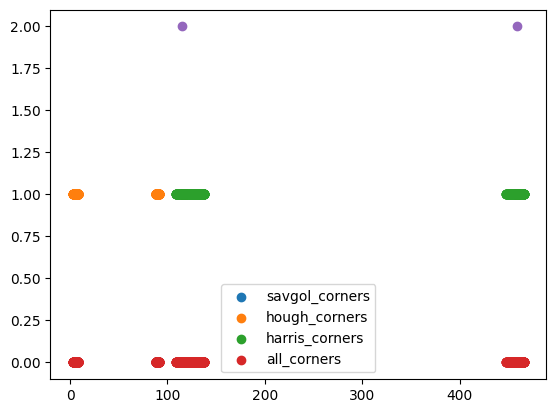

In [65]:
plt.scatter(savgol_corners, [1]*len(savgol_corners), label='savgol_corners')
plt.scatter(hough_corners, [1]*len(hough_corners), label='hough_corners')
plt.scatter(harris_corners, [1]*len(harris_corners), label='harris_corners')

all_corners = np.concatenate((savgol_corners, hough_corners, harris_corners))
# all_corners = hough_corners
plt.scatter(all_corners, np.zeros(len(all_corners)), label='all_corners')
plt.legend()

# Find only most dense clusters
from sklearn.cluster import DBSCAN

clf = DBSCAN(eps=20, min_samples=500).fit(all_corners.reshape(-1, 1))

# Find centers of clusters by taking means
centers = []
for i in (np.unique(clf.labels_)):
    if i != -1:
        ind = np.where(clf.labels_ == i)
        ind = all_corners[ind]
        centers.append(np.mean(ind))

centers = np.round(centers, 0)
corner_inds = centers.astype(int)

plt.scatter(centers, [2]*len(centers))

##### Combining angles and prediction difference

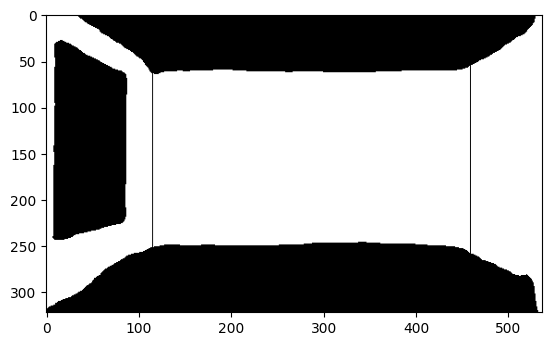

In [66]:
only_walls = np.array(segmented_img.copy())
only_walls[ind_0, ind_1] = [0, 0, 0]
only_walls[ind_2, ind_3] = [255, 255, 255]
only_walls[:, corner_inds] = [0, 0, 0]

plt.imshow(only_walls)

pil_image = pil.fromarray(only_walls)
pil_image.save("images/outputs/segmented-with-corners.png")

## Finding Geometry

##### Extracting Geometry

In [67]:

im = cv2.imread('images/outputs/segmented-with-corners.png')
assert im is not None, "file could not be read, check with os.path.exists()"
imgray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(imgray, 0, 1, 0)

# thresh = cv2.adaptiveThreshold(imgray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 3, 1)

# kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(10, 10))
# thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN,kernel)
contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

c:\Users\Kim\anaconda3\envs\pipeline1\lib\site-packages\ipykernel_launcher.py:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


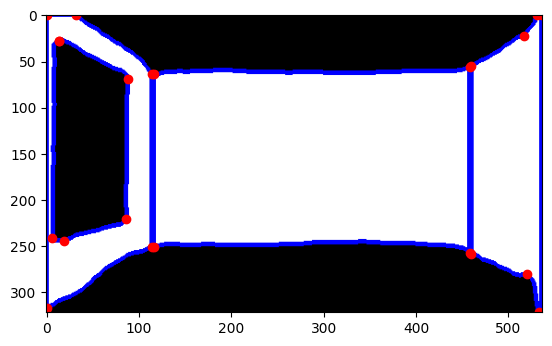

In [68]:
im_2 = im.copy()
final_cnt = []

for cnt in contours:
    x1,y1 = cnt[0][0]
    approx = cv2.approxPolyDP(cnt, 0.01*cv2.arcLength(cnt, True), False)

    # cv.putText(im_2, 'Rectangle', (x1, y1), cv.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 0), 2)
    im_2 = cv2.drawContours(im_2, [cnt], -1, (0,0,255), 3)
    plt.scatter(approx[:, 0, 0], approx[:, 0, 1], color="r")
    final_cnt.append(approx[:, 0, :])
    
plt.imshow(im_2)
final_cnt = np.array(final_cnt)

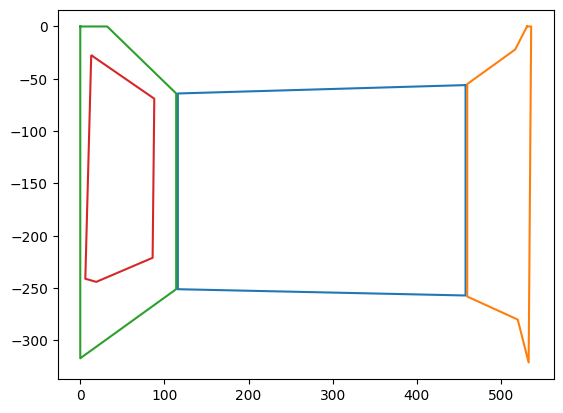

In [69]:
for i in range(len(final_cnt)):
    data = np.append(final_cnt[i], final_cnt[i][0]).reshape(-1, 2)
    
    plt.plot(np.array(data)[:, 0], -np.array(data)[:, 1])
    
# plt.scatter(corner_inds, [-150]*len(corner_inds))

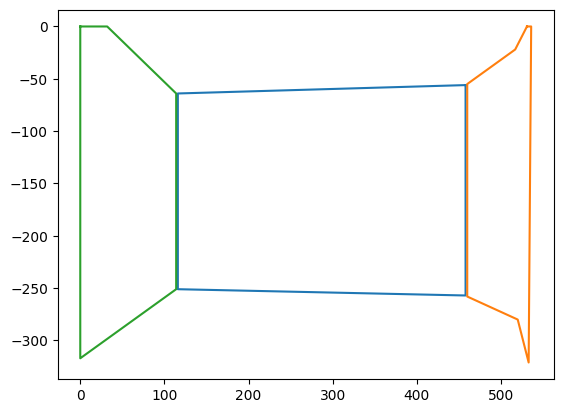

In [70]:
# Keep only shapes which have two points on the corner wall

corner_adj_geom = []

for i in range(len(final_cnt)):
    data = np.array(final_cnt[i])[:, 0]
    limit = 5
    
    diff_1 = np.sum(np.abs(data.copy() - corner_inds[0]) <= limit)
    diff_2 = np.sum(np.abs(data.copy() - corner_inds[1]) <= limit)
    
    if diff_1 >= 2 or diff_2 >= 2:
        corner_adj_geom.append(final_cnt[i])
        
for i in range(len(corner_adj_geom)):
    data = np.append(corner_adj_geom[i], corner_adj_geom[i][0]).reshape(-1, 2)
    
    plt.plot(np.array(data)[:, 0], -np.array(data)[:, 1])

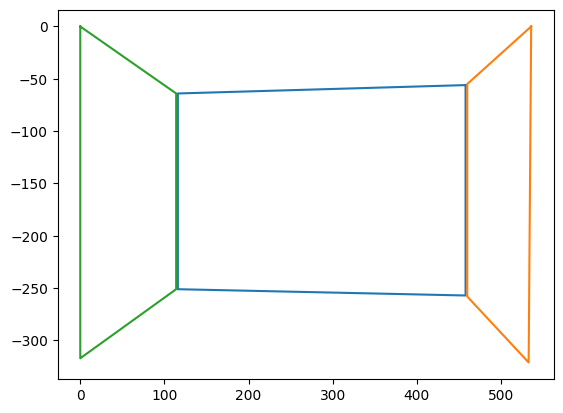

In [71]:
new_geom = []

# for each shape
for i in range(len(corner_adj_geom)):
    # try multiple thresholds
    for j in np.linspace(0.01, 0.1):
        # calc the polygon
        approx = cv2.approxPolyDP(corner_adj_geom[i], j*cv2.arcLength(corner_adj_geom[i], True), True)
        # if polygon has length of 4, keep it and break loop
        if len(approx) == 4:
            new_geom.append(approx)
            break

for i in range(len(new_geom)):
    data = np.append(new_geom[i], new_geom[i][0]).reshape(-1, 2)
    plt.plot(np.array(data)[:, 0], -np.array(data)[:, 1])

## Perspective Transformation

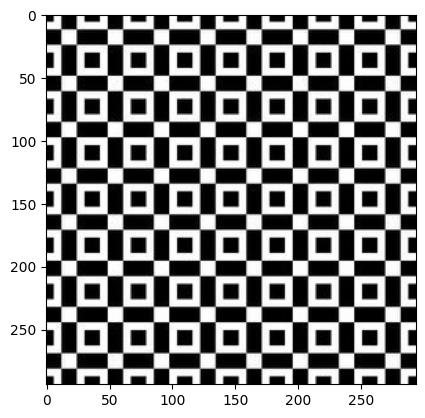

In [72]:
wallpaper = cv2.imread('images/inputs/wallpaper/squares.jpg')

plt.imshow(wallpaper)

### Transform wallpaper pattern

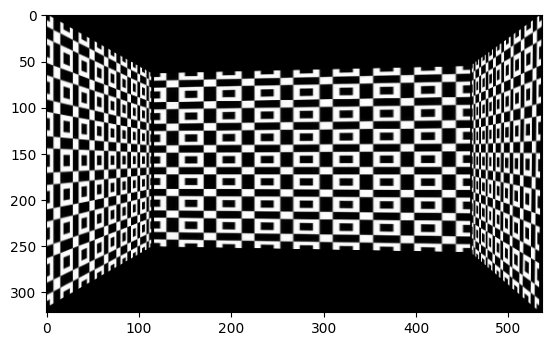

In [73]:
# find coordinates of corners of wallpaper image
shape = wallpaper.shape
corners = np.float32([[0,0], [0, shape[0]], [shape[1], shape[0]], [shape[1],0]])

# get size of output image
og = np.asarray(pil.open(filename))
size = (og.shape[1], og.shape[0])

walls = []

for wall in range(len(new_geom)):
    wall_coords = np.float32(new_geom[wall])

    matrix = cv2.getPerspectiveTransform(corners, wall_coords)
    result = cv2.warpPerspective(wallpaper, matrix, size)

    walls.append(result)

result = np.sum(walls, axis=0)

plt.imshow(result)

### Combine transformed wallpaper with original image

In [74]:
# new wall indices


result_new = np.array(og).copy()
geom_mask = []

for contour in new_geom:
    single_contour_mask = []
    for i in range(og.shape[0]):
        row = []
        for j in range(og.shape[1]):
            t = cv2.pointPolygonTest(contour, tuple([j, i]), False)
            if t in [1, 0]:
                row.append(1)
            else:
                row.append(0)      
        single_contour_mask.append(row)
    single_contour_mask = np.array(single_contour_mask)
    geom_mask.append(single_contour_mask)


geom_mask = np.amax(geom_mask, axis=0)


In [75]:
wall_mask = np.zeros([og.shape[0], og.shape[1]])
wall_mask[ind_2, ind_3] = 1


final_mask = np.zeros([og.shape[0], og.shape[1]])

for i in range(og.shape[0]):
    for j in range(og.shape[1]):
        if wall_mask[i,j] + geom_mask[i,j] == 2:
            final_mask[i,j] = 1 


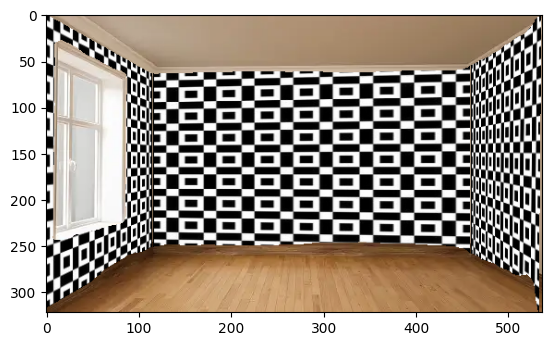

In [76]:
result_new = np.array(og).copy()
mask_ind_0, mask_ind_1 = np.where(final_mask == 1)
result_new[mask_ind_0, mask_ind_1] = result[mask_ind_0, mask_ind_1]
plt.imshow(result_new)

final_output = pil.fromarray(result_new)
final_output.save("images/outputs/final-outputs/final-output.png")